In [2]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
reload(utils)

Welcome to ROOTaaS 6.06/05


<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [3]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
print utils.IO.ldata
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
signalName=utils.IO.ldata+ntuples+"/"+''.join(signal)
print "using signal file:"+signalName
background = [s for s in files if "DiPhotonJets" in s]
backgroundName=utils.IO.ldata+ntuples+"/"+''.join(background)
print "using background file:"+backgroundName

/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/
env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using signal file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root
using background file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root


In [4]:
import numpy as np

In [5]:
#normal variables: int, float, vectors...
branch_names = 'npu,genTotalWeight'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

#tlorentz vectors
branch_names_lorentz = 'leadingJet,leadingPhoton'.split(",")
branch_names_lorentz = [c.strip() for c in branch_names_lorentz]
branch_names_lorentz = (b.replace(" ", "_") for b in branch_names_lorentz)
branch_names_lorentz = list(b.replace("-", "_") for b in branch_names_lorentz)
print branch_names_lorentz

#variables we want to access in tlorenz vector
branch_names_lorentz_var = 'Pt(),Eta()'.split(",")
branch_names_lorentz_var = [c.strip() for c in branch_names_lorentz_var]
branch_names_lorentz_var = (b.replace(" ", "_") for b in branch_names_lorentz_var)
branch_names_lorentz_var = list(b.replace("-", "_") for b in branch_names_lorentz_var)
print branch_names_lorentz_var

['leadingJet', 'leadingPhoton']
['Pt()', 'Eta()']


In [6]:
import pandas as pd
import root_pandas as rpd
reload(rpd)

# doesn't work the alias bbggSelectionTree.SetAlias("leadingJetPt","leadingJet.Pt()")
#signal_df = rpd.read_root("prova.root","daje", columns = branch_names) 

#this is my modified version of root_pandas library
signal_df = rpd.read_root_LorentzVector(signalName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
lorentz_var)
import numpy as np
signal_df.to_csv('/tmp/micheli/prova.csv',',',mode='w')


#signal_df = pd.root2array(signalName, "bbggSelectionTree", branch_names)

leadingJet
leadingJet
leadingPhoton
leadingPhoton
['genWeights', 'genTotalWeight', 'gen_mHH', 'gen_cosTheta', 'gen_NRW', 'leadingPhoton', 'leadingPhotonID', 'leadingPhotonISO', 'leadingPhotonEVeto', 'leadingPhotonIDMVA', 'customLeadingPhotonIDMVA', 'leadingPhotonR9full5x5', 'leadingPhotonHasGain1', 'leadingPhotonHasGain6', 'subleadingPhoton', 'subleadingPhotonID', 'subleadingPhotonISO', 'subleadingPhotonEVeto', 'subleadingPhotonIDMVA', 'customSubLeadingPhotonMVA', 'subleadingPhotonR9full5x5', 'subLeadingPhotonHasGain1', 'subLeadingPhotonHasGain6', 'diphotonCandidate', 'nPromptInDiPhoton', 'leadingJet', 'leadingJet_KF', 'leadingJet_Reg', 'leadingJet_RegKF', 'leadingJet_bDis', 'leadingJet_CSVv2', 'leadingJet_cMVA', 'leadingJet_flavour', 'leadingJet_hadFlavour', 'subleadingJet', 'subleadingJet_KF', 'subleadingJet_Reg', 'subleadingJet_RegKF', 'subleadingJet_bDis', 'subleadingJet_CSVv2', 'subleadingJet_cMVA', 'subleadingJet_flavour', 'subleadingJet_hadFlavour', 'dijetCandidate', 'dijetCandi

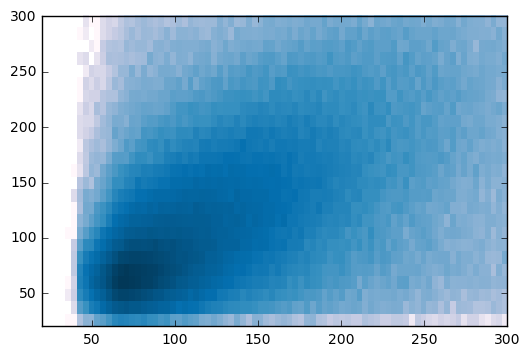

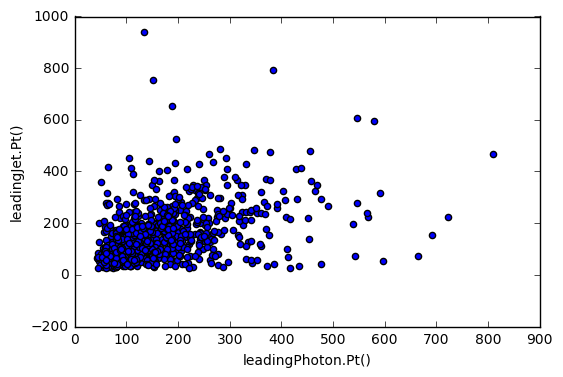

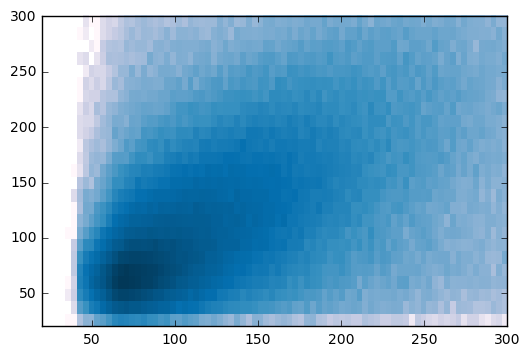

In [11]:
import random
import matplotlib.pyplot as plt
#plot 1000 data points at random
signal_df.ix[random.sample(signal_df.index, 1000)].plot(kind='scatter',
                                          x='leadingPhoton.Pt()', y='leadingJet.Pt()')
plt.show()
from matplotlib.colors import LogNorm
plt.hist2d(x=signal_df['leadingPhoton.Pt()'],y=signal_df['leadingJet.Pt()'],
            range=[[20,300],[20,300]],bins=[80,25],norm=LogNorm(),cmap='PuBu')
plt.show()

In [23]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)
import numpy as np
data_train = np.loadtxt( '/tmp/micheli/prova.csv', delimiter=',', skiprows=1 )
# Pick a random seed for reproducible results. Choose wisely!
np.random.seed(42)
# Random number for training/validation splitting
r =np.random.rand(data_train.shape[0])
Y_train = data_train[:,1][r<0.9]
X_train = data_train[:,3:7][r<0.9] 

print Y_train

#gbc = ensemble.GradientBoostingClassifier(n_estimators=50, max_depth=5,min_samples_leaf=200,max_features=10,verbose=1)
#gbc.fit(X_train,Y_train.astype('int')) 

#X = signal_df[['leadingJet.Pt()', 'leadingJet.Eta()', 'leadingPhoton.Pt()', 'leadingPhoton.Eta()']]
#y = signal_df[['npu']]
#W = signal_df[['genTotalWeight']]
#

[ 23.9771862   19.11550331  13.23758411 ...,  22.26027489  21.58580589
  32.31884766]


In [34]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)
reg = ensemble.GradientBoostingRegressor(max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-4)

import numpy as np
data_train = np.loadtxt( '/tmp/micheli/prova.csv', delimiter=',', skiprows=1 )
# Pick a random seed for reproducible results. Choose wisely!
np.random.seed(42)
# Random number for training/validation splitting
r =np.random.rand(data_train.shape[0])
Y_train = data_train[:,1][r<0.9]
X_train = data_train[:,3:7][r<0.9] 

Y_test = data_train[:,1][r>0.9]
X_test = data_train[:,3:7][r>0.9] 

#gbc = ensemble.GradientBoostingClassifier(n_estimators=50, max_depth=5,min_samples_leaf=200,max_features=10,verbose=1)
#gbc.fit(X_train,Y_train.astype('int')) 

#X = signal_df[['leadingJet.Pt()', 'leadingJet.Eta()', 'leadingPhoton.Pt()', 'leadingPhoton.Eta()']]
#y = signal_df[['npu']]
#W = signal_df[['genTotalWeight']]
#clf.fit(X_train,Y_train.astype('int'))
reg.fit(X_train,Y_train)
Y_pred = reg.predict(X_test)

[ 61.87340164  -1.44429994  60.23987633  -1.21404942]


[  61.87340164  236.48760986   76.13134003 ...,  125.84706116  133.26203918
  109.16719055]


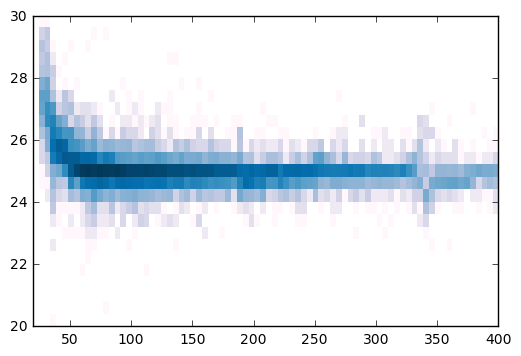

In [50]:
print X_test[:,0].ravel()
plt.hist2d(x=X_test[:,0].ravel(),y=Y_pred, range=[[20,400],[20,30]],bins=[80,25],norm=LogNorm(),cmap='PuBu')
plt.show()